In [41]:
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# **Household electric consumption**
El dataset seleccionado registra los datos de consumo eléctrico de un hogar por minuto durante 4 años. Contiene 2,075,259 mediciones; desde diciembre de 2006 hasta noviembre del 2010. A continuación se detalla el contenido de cada columna:

- **Date:** Fecha en formato dd/mm/aa
- **Time:** Hora del registro en formato hh:mm:ss
- **Global active power:** Consumo promedio general del hogar por minuto (en kW)
- **Global reactive power:** Consumo promedio general reactivo por minuto (en kW)
- **Voltage:** Voltaje promedio por minuto (en V)
- **Global intensity:** Intensidad de corriente general en promedio por minuto (en Am)
- **Submetering_1:** Submedición de energía (en Watt por hora en estado activo). Corresponde a la cocina, donde hay un lavavajillas, una estufa y un horno de microondas.
- **Submetering_2:** Submedición de energía (en Watt por hora en estado activo). Corresponde al área de lavado donde hay una lavadora, una secadora, un refrigerador y una bombilla.
- **Submetering_3:** Submedición de energía (en Watt por hora en estado activo). Corresponde a un calentador de agua y un aire acondicionado.

Vemos que en este ejemplo es posible aplicar una RNN para predicción de series temporales debido a la naturaleza del registro de los datos. Los datos registrados son los pertenecientes a 4 años, cada minuto del día; para poder realizar una predicción es importante tener en cuenta los datos referentes a la hora, día, semana o año anterior, así como también es menester preservar el orden que tienen.


In [6]:
energy = pd.read_csv('household_power_consumption.txt',
                 sep=';', # el texto viene así separado
                 na_values=['nan','?'], # valores faltantes
                 low_memory=False # optimizar el tiempo, no ahorra memoria
                 )

In [4]:
energy.shape

(2075259, 9)

In [7]:
energy.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
# Creacion de columna datetime (índice)
energy['Datetime'] = pd.to_datetime(energy['Date'] + ' ' + energy['Time'], dayfirst=True)
energy.drop(columns=['Date','Time'], inplace=True)
energy = energy.set_index('Datetime')

In [9]:
energy.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [10]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [11]:
energy.shape

(2075259, 7)

In [14]:
# Datos faltantes
energy.isna().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [13]:
# Limpieza de datos
Imputer = SimpleImputer(strategy='mean') # se reemplaza los datos faltantes por el promedio
Energy = pd.DataFrame(Imputer.fit_transform(energy), columns=energy.columns, index=energy.index)

Energy.isna().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


<Axes: >

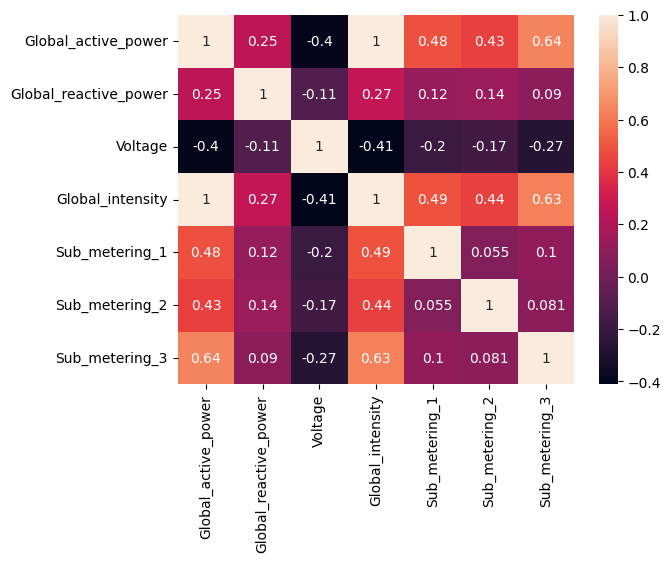

In [15]:
# Correlación general de las variables
correlacion_global = energy.corr()
sns.heatmap(correlacion_global, annot=True)

<Axes: >

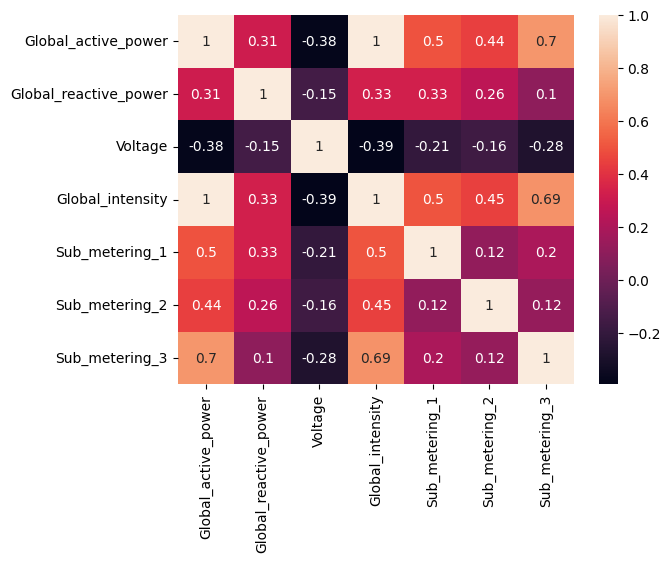

In [18]:
# Correlación por hora
correlacion_h = energy.resample('h').mean().corr()
sns.heatmap(correlacion_h, annot=True)

# **Tratamiento de datos**

La variable objetivo será 'Global active power' mientras que las variables 'Global_reactive_power' y 'Voltage' serán descartadas por tener una baja correlación con la variable objetivo.

Con el fin de reducir los tiempos de cómputo, se decidió analizar los datos agrupados por hora (en promedio) en lugar de por minuto como lo registra el dataframe original.

In [19]:
energy_hour = Energy.resample('h').mean()
energy_hour.shape

(34589, 7)

In [20]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(energy_hour.drop(columns=['Global_active_power', 'Global_reactive_power', 'Voltage']))

# Datos para el entrenamiento
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        Y.append(data[i + look_back, 0])  # Predice Global_active_power
    return np.array(X), np.array(Y)

look_back = 24*7 # se secciona por semanas
X, Y = create_dataset(train_scaled, look_back)

In [30]:
# División de datos
#n = 365*24 # se usa el primer año como datos de entrenamiento (por agilidad en el cómputo)
n = int(len(X)*0.8) # se utiliza el 80% de los datos para el entrenamiento

X_test, X_train = X[n:], X[:n]
Y_test, Y_train = Y[n:], Y[:n]


# **Modelo LSTM**

Para esta base de datos se debe tener en cuenta que el consumo eléctrico puede variar por distintas razones a diferentes horas del día en distintos dias; lo que hace que los registros sean altamente variables.

En esta ocasión se optó por utilizar el optimizador Adam para evitar la constante configuraciones de lotes y épocas y al mismo tiempo ahorrar tiempo de cómputo.

In [33]:
# Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 168, 100)       │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
modelo_t = model.fit(X_train, Y_train, epochs=50, batch_size=128, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 182s 841ms/step - loss: 0.0089 - val_loss: 0.0061
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 181s 840ms/step - loss: 0.0084 - val_loss: 0.0057
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 185s 855ms/step - loss: 0.0080 - val_loss: 0.0056
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 180s 833ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 175s 812ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 206s 833ms/step - loss: 0.0074 - val_loss: 0.0056
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 203s 837ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 181s 840ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 202s 841ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 10/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 174s 804ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 11/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 209s 838ms/step - loss: 0.0071 - val_loss: 0.0051
Epoch 12

# **Visualización**

In [45]:
prediccion = model.predict(X_test)

real_datos = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1,1),
                                                           np.zeros((len(Y_test),
                                                                     train_scaled.shape[1]-1))), axis=1))[:,0]

prediccion_datos = scaler.inverse_transform(np.concatenate((prediccion,
                                                              np.zeros((len(prediccion),
                                                                        train_scaled.shape[1]-1))), axis=1))[:,0]


216/216 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step


In [46]:
# rmse score
rmse = np.sqrt(mean_squared_error(real_datos, prediccion_datos))
rmse

np.float64(2.0179377059878147)

In [47]:
# r2 score
r_2 = r2_score(real_datos, prediccion_datos)
print(f'R^2 score:{r_2}')

R^2 score:0.5536801903995692


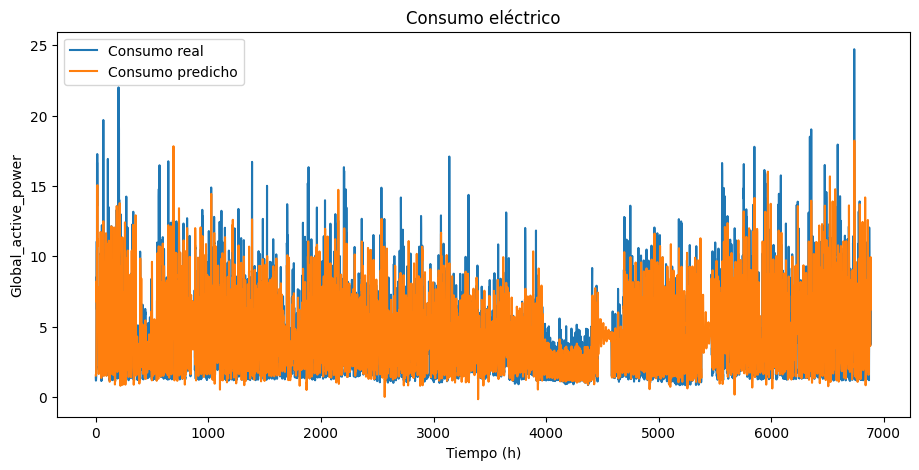

In [48]:
# Gráfico con matplotlib
plt.figure(figsize=(11,5))
plt.plot(real_datos, label='Consumo real')
plt.plot(prediccion_datos, label='Consumo predicho')
plt.title('Consumo eléctrico')
plt.xlabel('Tiempo (h)')
plt.ylabel('Global_active_power')
plt.legend()
plt.show()

In [49]:
# Grafica con plotly
fig = go.Figure()
# Valores reales
fig.add_trace(go.Scatter(y=real_datos, mode='lines', name='Consumo real', line=dict(color='red')))
# Predicción
fig.add_trace(go.Scatter(y=prediccion_datos, mode='lines', name='Consumo predicho', line=dict(color='blue')))

fig.update_layout(title='Consumo eléctrico',
                  xaxis_title='Tiempo (h)',
                  yaxis_title='Global active power (kW)')
fig.show()

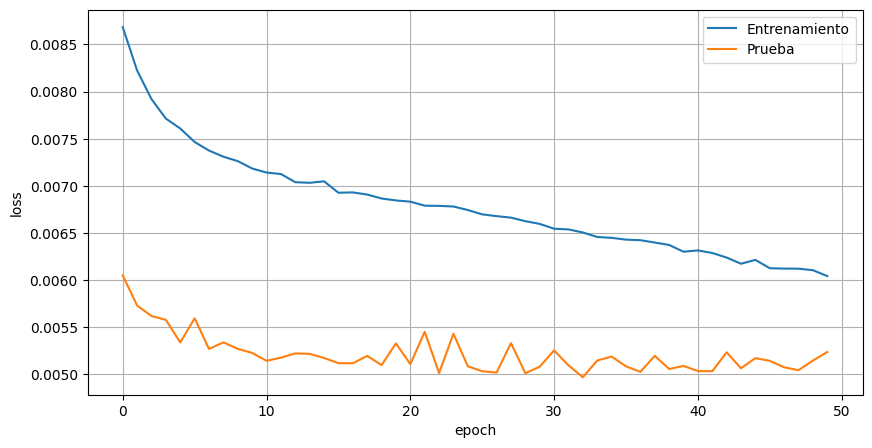

In [50]:
plt.figure(figsize=(10,5))
plt.plot(modelo_t.history['loss'], label='Entrenamiento')
plt.plot(modelo_t.history['val_loss'], label='Prueba')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# exportar el 10% de los datos
df_small = energy.head(int(len(energy)*0.1))
df_small.to_csv('fraccion1.txt', sep=';', index=False)